# Validation of spot counting pipelines 

The aim of this notebook is to quantitatively compare different spot counting pipelines, so that we can robustly identify which parameters are best, and to be able to do quality control on new data. 

We are using a dataset from the Allen Institute for Cell Science : https://scikit-image.org/docs/stable/api/skimage.data.html#skimage.data.cells3d 

And I manually annotated centroids of these cells in napari. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io

import pyclesperanto_prototype as cle

# comment this out if you don't have an RTX-type GPU
cle.select_device('RTX')
cle.get_device()

/home/clement/mambaforge/envs/BioImageAnalysisNotebooks/lib/python3.12/site-packages/pyclesperanto_prototype/_tier0/_device.py:77: UserWarning: No OpenCL device found with RTX in their name. Using pthread-11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz instead.
  warnings.warn(f"No OpenCL device found with {name} in their name. Using {device.name} instead.")


<pthread-11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz on Platform: Portable Computing Language (2 refs)>

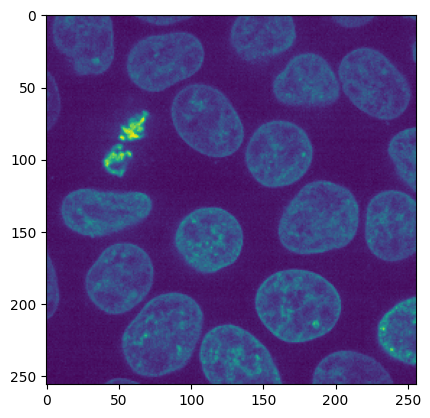

In [2]:
anisotropy = 4 # note that this image is anisotropic, which means the distance measurements are inaccurate. For non-demo data I should fix this.

# load cell positions
annotations = np.genfromtxt('../../data/cells3d_annotations.csv', delimiter=',')
annotations = annotations[1:, 1:]

# load image and show a central point
img = skimage.io.imread('../../data/cells3d_nuclei.tif')
plt.imshow(img[30])

## Spot detection 

We have a basic spot detection algorithm, that just does a gaussian blur on the image and detects local maxima of pixels. 

In [3]:
def process_chunk(img, sigmaxy, radius_xy):
    input_image = cle.push(img)
    starting_point = cle.gaussian_blur(input_image, sigma_x=sigmaxy, sigma_y=sigmaxy, sigma_z = sigmaxy/anisotropy)
    maxima = cle.detect_maxima_box(starting_point, radius_x=radius_xy, radius_y = radius_xy, radius_z=radius_xy/anisotropy)
    # print(np.sum(cle.pull(maxima)))
    labeled_maxima = cle.label(maxima)
    pointlist = cle.centroids_of_labels(labeled_maxima)
    detected_spots = np.zeros(shape = pointlist.shape)
    # this reshaping ensures that detected and annotated spots share the same axis order
    detected_spots[0] = pointlist[2]
    detected_spots[1] = pointlist[1]
    detected_spots[2] = pointlist[0]
    detected_spots = detected_spots.T
    detected_spots = detected_spots[~np.isnan(detected_spots).any(axis=1)]
    return(detected_spots.T)


sigmaxy = 10;
radius_xy = 15;

detected_spots = process_chunk(img, sigmaxy, radius_xy)

size: 60


One could visualize the outcomes of this spot detection in 3d using napari: 

In [4]:
# this is commented out because napari interferes with inline graphics
# import napari

# viewer = napari.Viewer()

# viewer.add_image(img)
# viewer.add_points(annotations, size = 3)
# viewer.add_points(detected_spots.T, size = 3, face_color='blue')

We can now compute the distances between ground truth (manually annotated) centroids. We do this by generating a distance matrix in pyclesperanto: each row and column represents one detected cell, and the distance is represented by the value in the grid entry/colour intensity, in the graphic below. 

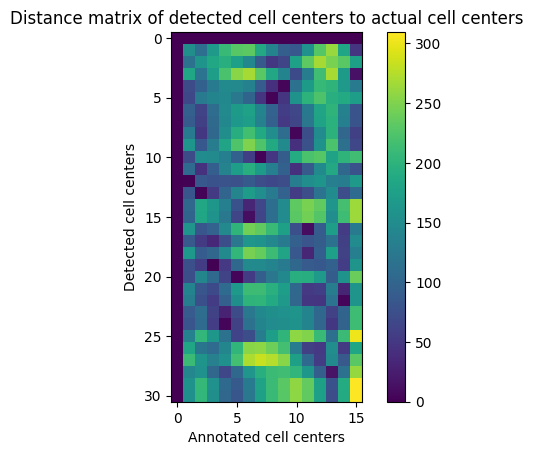

In [5]:
distance_matrix_of_actual_cells = cle.generate_distance_matrix(annotations.T, annotations.T)
distance_matrix = cle.generate_distance_matrix(annotations.T, detected_spots)

plt.imshow(distance_matrix)
plt.xlabel('Annotated cell centers')
plt.ylabel('Detected cell centers')
plt.title('Distance matrix of detected cell centers to actual cell centers')
plt.colorbar()

## Measuring the distance between nearest neighbour cells 

As a sanity check, we want to know the minimum distance between nearest neighbour cells, and the minimum distance between ground truth and predicted cell centres. If our spot detection pipeline is perfect, we would expect the minimum distance between ground truth and predicted cell centres to be consistently much smaller than the minimum distance between cells. I calculated this by computing the minimum projection along the x axis, thus obtaining the nearest neighbour cell. 

In our data, on average, neighbouring cells in the ground truth data are ~50 pixels apart, and most of detected spots are less than 10 pixels from annotated spots. Therefore our spot detection pipeline is good. However note there are two detected spots that are a long way from annotations, these may be false positives. 

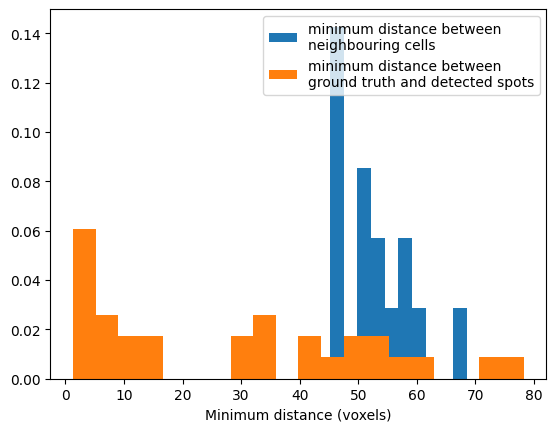

In [6]:
# Any cells of 0 distance from each other are the same cell, so we want to exclude them
# it would be neater to overwrite the diagonal
distance_matrix_of_actual_cells = cle.replace_intensity(distance_matrix_of_actual_cells, value_to_replace = 0, value_replacement = 1000)

minimum_dist = np.asarray(cle.minimum_x_projection(distance_matrix_of_actual_cells[1:, 1:]))
# [1:, 1:] is necessary to get rid of background
values, bins, _ = plt.hist(minimum_dist.flatten(), density=True, label = 'minimum distance between \nneighbouring cells')

minimum_dist = np.asarray(cle.minimum_x_projection(distance_matrix[1:, 1:]))
values, bins, _ = plt.hist(minimum_dist.flatten(), density=True, bins = 20, label = 'minimum distance between \nground truth and detected spots')
plt.xlabel('Minimum distance (voxels)')

plt.legend()

## Quantifying true and false positives 

We now want to use this information to identify true and false positive cells. To achieve this, we need to define a distance threshold $d$, between which two points are defined as being part of the same cell. We can also use the above histogram to choose $d$. This value needs to be smaller than the minimum distance between neighbouring cells, and larger than the distance error we can tolerate between ground truth and detected cells. For our data, we will use for example 30 voxel. 

We can now count true and false positive cells. If our spot detection was perfect, every row and column in the distance matrix would have exactly one entry below the threshold $d$, ie one correctly detected spot (true positives). This is not the case, and so we will define 

1. false positives as spots in the prediction but not the ground truth: eg. columns with no cells within distance $d$;
2. false negatives as cells present in the ground truth but not prediction; ie rows with no cells within distance $d$; 
3. and ambiguous matches as columns with more than one match. 

From this we can calculate F1 score.

In [13]:
def compute_true_positives(distance_matrix, thresh):
    distance_matrix = distance_matrix[1:,1:] # get rid of background
    count_matrix = distance_matrix < thresh

    y_proj = np.asarray(cle.sum_y_projection(count_matrix))

    # false negatives are present in the GT but not the prediction
    false_negatives = len(y_proj[y_proj==0])

    # finally, to detect false positives, we want to identify any cells present in the detected spots but not GT
    x_proj = np.asarray(cle.minimum_x_projection(distance_matrix)).ravel() < thresh
    false_positives = len(x_proj[x_proj == 0])

    # we want to exclude any detection that are far from annotation or close to more than one annotation
    x_proj = np.asarray(cle.sum_x_projection(count_matrix)).T
    x_args = np.argwhere(x_proj == 1)[:, 1]
    count_matrix_filtered = np.array(count_matrix)[x_args, :]

    detected = np.asarray(cle.sum_y_projection(count_matrix_filtered))

    # true positive are annotation with exactly one detection and that detection has only one annotation
    mask = np.bitwise_and(detected==1, y_proj==1)
    true_positives = len(detected[mask])

    # ambiguous matches occur when one annotation corresponds to multiple detected spots or vice versa
    ambiguous_matches = len(y_proj[0]) - true_positives - false_negatives

    return([true_positives, false_positives, false_negatives, ambiguous_matches])


def compute_f1(metrics):
    tp, fp, fn, am = metrics
    return((tp) / (tp + 0.5 * (fn + fp + am)))

print('The F1 score is: ')
print(round(compute_f1(compute_true_positives(distance_matrix, 30)), 2))

print('The number of ambiguious matches is: ')
print(compute_true_positives(distance_matrix, 30)[3])

print(f'We are detecting {distance_matrix.shape[0]} cells when there are {distance_matrix.shape[1]}')

The F1 score is: 
0.62
The number of ambiguious matches is: 
0
We are detecting 31 cells when there are 16


Finally, it makes sense to check that our somewhat arbitrary choice of distance threshold didn't bias our results. 

I've done this by computing the true and false positives for different values of $d$. For very small $d$, there are fewer true positives and more false positives: this is because $d$ is much smaller than the nucleus diameter, so missed cells are a consequence of differences between where the human annotator and the algorithm place the spots, not genuine mis-detection. For $d$ > 40, the false positive rate decreases, as mis-annotated spots could be erronously assigned to the wrong cells. 

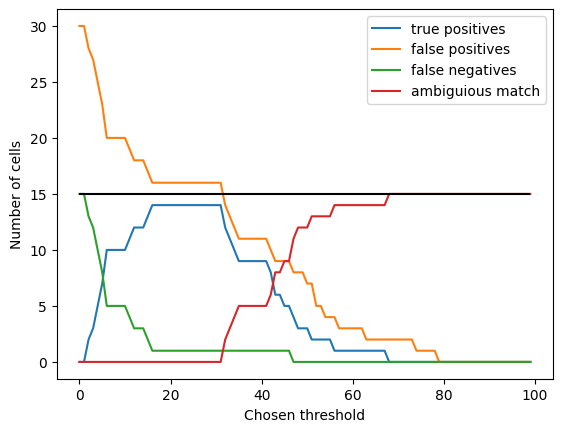

In [14]:

# after the metrics unloaded paper, I should be defining my true/false positives based on a range of values
# not simply one arbitrary distance threshold

array = []

threshold_range = range(0, 100)

tp = annotations.shape[0]

for j in threshold_range:
    p = compute_true_positives(distance_matrix, j)
    array.append(np.array(p))

plt.plot(threshold_range, np.array(array)[:, 0], label = 'true positives')

plt.plot(threshold_range, np.array(array)[:, 1], label = 'false positives')

plt.plot(threshold_range, np.array(array)[:, 2], label = 'false negatives')

plt.plot(threshold_range, np.array(array)[:, 3], label = 'ambiguious match')

plt.hlines(xmin = min(threshold_range), xmax = max(threshold_range), y = tp, color = 'k')

plt.xlabel('Chosen threshold')
plt.ylabel('Number of cells')

plt.legend()